# Olfactory Bulb Glomerular Segmentation & Trace Extraction (Batch Processing)

**Goal:** Process a directory of two-photon imaging movies from individual trials. This notebook will:
1.  Create a representative "sampling movie" from random frames across all trials.
2.  Perform segmentation (CNMF) on this sampling movie to find a single, stable set of ROIs for the entire session.
3.  Loop through each individual trial video, apply motion correction, and extract fluorescence traces (F, dF/F, Z) using the common ROIs.
4.  Save all ROI information and all per-trial traces into a single, consolidated HDF5 file for easy downstream analysis.

**What you get at the end:**

1.  **Summary Figures** — Visual quality control for the segmentation performed on the sampling movie.
2.  **Single HDF5 Output** — A structured HDF5 file containing:
    -   Global ROI information (pixel locations, weights).
    -   Per-trial fluorescence traces for every kept ROI.
    -   All processing metadata and paths to summary figures.

### 0) Environment & Dependencies

*   Requires **CaImAn** and a typical scientific Python stack (`numpy`, `pandas`, `scipy`, `matplotlib`, `scikit-image`, `tifffile`).
*   Requires `h5py` for saving the final output. You can install it with `pip install h5py`.
*   Tested with Python 3.10–3.11 and CaImAn ≥ 1.9.

In [2]:
# --- Imports & Basic Setup ---
import os, sys, warnings, json, logging, h5py, re
from datetime import datetime
from pathlib import Path
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import display
from tqdm.notebook import tqdm

# --- CalmAn imports ---
try:
    import caiman as cm
    from caiman.motion_correction import MotionCorrect
    from caiman.source_extraction.cnmf import params as caiman_params
    from caiman.source_extraction import cnmf as cnmf_mod
    from caiman.utils.visualization import plot_contours
    from caiman.cluster import setup_cluster, stop_server
except ImportError as e:
    raise ImportError("CaImAn not found. Please install CaImAn.") from e

from skimage.measure import regionprops
import scipy.ndimage

# --- Matplotlib defaults ---
plt.rcParams["figure.dpi"] = 120

# --- Suppress repetitive warnings ---
warnings.filterwarnings("ignore", message=".*nperseg.*", category=UserWarning)
warnings.filterwarnings("ignore", message=".*pkg_resources is deprecated.*", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

/Users/mosse/miniforge3/envs/caiman/lib/python3.11/site-packages/caiman/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### 1) Configure Paths & Parameters

**You must edit the `session_dir` variable in the cell below.** This should be the path to the main folder for your imaging session, which must contain a subdirectory named `raw` with your `.tif` files.

*   **Paths**:
    *   `session_dir`: The main directory for your experiment.
    *   `mcor_dir`: The subdirectory containing your trial videos (must be named `mcor`).
    *   `out_dir`: Where all outputs will be saved.
*   **Sampling**:
    *   `num_random_frames_per_trial`: The number of frames to randomly select from each trial video to build the segmentation movie.
*   **Acquisition & Heuristics**:
    *   `fr_manual`, `decay_time`, `dxy`, `w10`: These are the same core parameters as the single-file notebook and should be set based on your imaging setup.

In [3]:
# --- YOU MUST EDIT THIS --- 
# Path to the main session directory, which must contain a 'mcor' subfolder.
session_dir = Path("/Volumes/MossLab/ImagingData/20250829/e1/processed/")
parent_dir = Path("/Volumes/MossLab/ImagingData/20250829/e1/")
# --- END EDIT --- 

# --- Derived Paths ---
mcor_dir = session_dir / "mcor"
raw_dir = parent_dir / "raw"
out_dir = session_dir / "outputs"
out_dir.mkdir(exist_ok=True, parents=True)
assert mcor_dir.is_dir(), f"Input directory '{mcor_dir}' not found!"
assert raw_dir.is_dir(), f"Raw scanimage tiff files directory '{raw_dir}' not found!"


# --- Sampling Parameters ---
num_random_frames_per_trial = 5 # Number of frames to pull from each trial video

# --- Acquisition / field-of-view info ---
fr_manual = 20.0
decay_time = 0.1
dxy = (2, 2)
w10 = 20 # should be ~the diameter of a small glomerulus in pixels (for .5 pix/um, 20 pixels (40um) is good)

# --- DERIVED PARAMETERS and parameters for CNMF fitting and refinement ---
mc_opts = dict(
    strides=(w10, w10), overlaps=(w10 // 2, w10 // 2), 
    max_shifts=(w10 // 2, w10 // 2), max_deviation_rigid=w10 // 4, pw_rigid=True)
K = 3
gSig = np.array([w10 // 2, w10 // 2])
gSiz = 2 * gSig + 1
min_SNR = 1.0
rval_thr = 0.3
merge_thr = 0.95
# --- post CaImAn refinement/exclusion by --- 
threshold_percentile = 15
convolution_threshold = 50
min_pixels = ((w10) ** 2) / 4
max_pixels = ((w10) ** 2) * 6

# --- Export Paths ---
sampling_movie_path = out_dir / "sampling_movie_for_segmentation.tif"
export_hdf5 = out_dir / "batch_analysis_results.hdf5"
summary_fig_A = out_dir / "summary_corr_max_overlays.png"
summary_fig_B_pdf = out_dir / "roi_panels.pdf"

print("Input trial directory:", mcor_dir.resolve())
print("Outputs will be saved under:", out_dir.resolve())

Input trial directory: /Volumes/MossLab/ImagingData/20250829/e1/processed/mcor
Outputs will be saved under: /Volumes/MossLab/ImagingData/20250829/e1/processed/outputs


### 2) Utility Functions

This cell contains all helper functions for the batch pipeline. This includes new functions for creating the sampling movie and for applying ROIs to extract traces from individual trials. You don't need to modify anything here.

In [12]:
def get_valid_tiff_files(directory):
    """
    Finds all TIFF files in a directory, robustly ignoring hidden macOS 
    resource files (those starting with '._').
    """
    all_files = sorted(list(directory.glob('*.tif')) + list(directory.glob('*.tiff')))
    valid_files = [f for f in all_files if not f.name.startswith('._')]
    return valid_files

def create_sampling_movie(mcor_dir, output_path, num_frames_per_trial, fr):
    """
    Creates a movie by sampling random frames ONLY from the 4-6 second window
    of each trial video.
    """
    all_frames = []
    trial_files = get_valid_tiff_files(mcor_dir)
    
    if not trial_files:
        raise FileNotFoundError(f"No valid TIFF files found in {mcor_dir}")
    
    print(f"Found {len(trial_files)} valid trial videos. Sampling frames from 4-6s window...")

    for trial_path in tqdm(trial_files, desc="Sampling trials"):
        with tifffile.TiffFile(trial_path) as tif:
            num_total_frames = len(tif.series[0].pages)
            
            # --- TARGETED FRAME SELECTION ---
            start_s, end_s = 5.0, 7.0       ### These parameters are editable
            start_frame = int(start_s * fr)
            end_frame = int(end_s * fr)
            
            # Ensure the window is valid for the current movie's length
            end_frame = min(end_frame, num_total_frames)

            # If the calculated start time is already past the end of the movie, skip this trial.
            if start_frame >= end_frame:
                print(f"\n  - WARNING: Skipping {trial_path.name}. It is shorter than {start_s} seconds.")
                continue
            
            # Create the pool of valid indices from the 4-6 second range
            valid_indices_pool = np.arange(start_frame, end_frame)
            
            # Determine how many frames we can actually sample
            num_to_sample = min(num_frames_per_trial, len(valid_indices_pool))
            
            if num_to_sample == 0:
                continue # Skip if there are no frames in the window

            # Select random frame indices from our targeted pool
            frame_indices = np.random.choice(
                valid_indices_pool,
                size=num_to_sample,
                replace=False
            )
            
            # Read ONLY the selected frames
            selected_frames = tif.asarray(key=frame_indices)
            all_frames.append(selected_frames)
            

    if not all_frames:
        raise ValueError("No frames were sampled. This could happen if all trial videos are shorter than 4 seconds.")

    sampling_movie = np.concatenate(all_frames, axis=0)
    tifffile.imwrite(output_path, sampling_movie)
    print(f"\nSaved sampling movie with {sampling_movie.shape[0]} frames to: {output_path}")
    return output_path, sampling_movie
    
def extract_traces_for_trial(trial_movie, cleaned_A_list, dims, fr, percentile_q=8, baseline_win_max=1000):
    """Extracts F, dF/F, and Z traces for a single trial movie using pre-computed ROIs."""
    T = trial_movie.shape[0]
    d1, d2 = dims
    
    # Combine cleaned A components into a single sparse matrix
    # cleaned_A_list is a list of flat (d1*d2,) arrays
    A_cleaned = csr_matrix(np.stack(cleaned_A_list, axis=1))
    Yr = trial_movie.reshape((T, -1), order="F").T
    
    # Raw Fluorescence (F)
    F_weighted = A_cleaned.T @ Yr
    
    # Z-score
    mean_F = F_weighted.mean(axis=1, keepdims=True)
    std_F = F_weighted.std(axis=1, keepdims=True)
    std_F[std_F == 0] = 1 # Avoid division by zero for silent ROIs
    Z_traces = (F_weighted - mean_F) / std_F
    
    # dF/F
    
    def rolling_percentile(arr, q=percentile_q, win=None):
        win = win or min(baseline_win_max, 2 * (T // 10) + 1)
        return pd.DataFrame(arr.T).rolling(win, center=True, min_periods=1).quantile(q/100).to_numpy().T

    F0 = rolling_percentile(F_weighted)
    dFF_traces = (F_weighted - F0) / np.maximum(F0, 1e-6)
    
    return np.asarray(F_weighted), np.asarray(dFF_traces), np.asarray(Z_traces)

def save_batch_hdf5_output(output_path, df_pixels, all_trial_data, metadata_dict):
    """Saves all batch analysis outputs into a single structured HDF5 file."""
    with h5py.File(output_path, 'w') as f:
        # Save global ROI pixel info
        roi_info_group = f.create_group('roi_info')
        for col in df_pixels.columns:
            data = df_pixels[col].values
            if data.dtype == 'object': data = data.astype(str).astype(np.string_)
            roi_info_group.create_dataset(col, data=data)
        
        # Save per-trial data in separate groups
        trials_group = f.create_group('trials')
        for trial_name, trial_traces in all_trial_data.items():
            trial_group = trials_group.create_group(trial_name)
            trial_group.create_dataset('raw_F', data=trial_traces['F'])
            trial_group.create_dataset('dFF', data=trial_traces['dFF'])
            trial_group.create_dataset('z_score', data=trial_traces['Z'])
        
        # Save metadata as attributes
        meta_group = f.create_group('metadata')
        for key, val in metadata_dict.items():
            try:
                meta_group.attrs[key] = str(val) if isinstance(val, (dict, list, tuple, Path)) else val
            except TypeError:
                 meta_group.attrs[key] = str(val)
    print(f"Successfully saved all batch data to: {output_path}")



# --- functions from previous single video notebook ----

def get_scanimage_fps(movie_path, default_fr=None):
    try:
        with tifffile.TiffFile(movie_path) as tf:
            si_meta = getattr(tf, "scanimage_metadata", None)
            if isinstance(si_meta, dict):
                fps = si_meta.get("FrameData", {}).get("SI.hRoiManager.scanFrameRate")
                if fps: return float(fps)
    except Exception: pass
    return default_fr

def compute_qc_images(movie, q_low=5, q_high=98):
    movie_no_nan = np.nan_to_num(movie, nan=-np.inf)
    max_proj = np.max(movie_no_nan, axis=0)
    corr_img = cm.local_correlations(movie, swap_dim=False)
    corr_img[np.isnan(corr_img)] = 0
    vmax1, vmin1 = np.percentile(max_proj.ravel(), q_high), np.percentile(max_proj.ravel(), q_low)
    vmax2, vmin2 = np.percentile(corr_img.ravel(), q_high), np.percentile(corr_img.ravel(), q_low)
    return (max_proj, (vmin1, vmax1)), (corr_img, (vmin2, vmax2))

def build_cnmf_params(movie_path_str, frame_rate, dxy_tuple):
    rf_target, stride_target = int(w10 + 2), int(2 * w10 / 3)
    opts_dict = {"data": {"fnames": [movie_path_str], "fr": float(frame_rate), "dxy": tuple(map(float, dxy_tuple))},"decay_time": decay_time,"patch": {"rf": rf_target, "stride": stride_target, "only_init": False},"init": {"K": int(K), "gSig": [int(gSig[0]), int(gSig[1])], "gSiz": [int(gSiz[0]), int(gSiz[1])], "ssub": 1, "tsub": 1, "rolling_sum": False, "normalize_init": True, "center_psf": True, "nb": 1, "method_init": "greedy_roi"},"preprocess": {"check_nan": True},"temporal": {"p": 0},"merging": {"do_merge": True, "merge_thr": merge_thr},"quality": {"min_SNR": float(min_SNR), "rval_thr": float(rval_thr)}}
    return caiman_params.CNMFParams(params_dict=opts_dict)
    
def fit_cnmf(images, params, n_processes=1, dview=None):
    """
    Fits and robustly refits CNMF by first converting the input movie to
    CaImAn's native memory-mapped format. This ensures both fit and refit work correctly.
    """
    info = {"used_fit_file": True, "did_refit": False, "delta_C_rms": None}
    
    # 1. Convert the in-memory `images` array to a CaImAn-native memmapped file.
    print("  - Converting sampling movie to CaImAn's native memory-mapped format...")
    caiman_mmap_path = cm.save_memmap([images], base_name='caiman_refit_movie_', order='C')
    print(f"  - Created temporary CaImAn-native file: {caiman_mmap_path}")

    # 2. Initial Fit (using the reliable CaImAn-native file path)
    model = cnmf_mod.CNMF(n_processes=n_processes, params=params, dview=dview)
    model.fit_file(caiman_mmap_path)
    print(f"[CNMF] Components after initial fit: {model.estimates.A.shape[1]}")

    # 3. Robust Refit Step
    C_before = np.array(model.estimates.C, copy=True)
    
    try:
        print("  - Refitting components using the CaImAn-native movie...")
        
        # --- THIS IS THE FIX ---
        # Load the CaImAn-native file into an object that refit() can use.
        # This object has the .shape attribute that the error message referred to.
        images_for_refit = cm.load(caiman_mmap_path)
        
        # The refit method requires a writable, float32 version of the data.
        images2 = np.array(images_for_refit, dtype=np.float32, order="F", copy=True)
        np.nan_to_num(images2, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
        
        # Pass the loaded movie object, not the string path.
        cnmf_refit = model.refit(images2)
        # --- END FIX ---

        info["did_refit"] = True
        
        C_after = np.array(cnmf_refit.estimates.C, copy=True)
        if C_before is not None and C_after is not None and C_before.shape == C_after.shape:
            diff = C_after - C_before
            rms = float(np.sqrt(np.mean(diff**2))) if diff.size > 0 else 0.0
            info["delta_C_rms"] = rms
            print(f"  - Refit complete. Delta C RMS: {rms:.6g}")
        
        print(f"[CNMF] Components after refit: {cnmf_refit.estimates.A.shape[1]}")
        return cnmf_refit, info
    
    except Exception as e:
        print("\n" + "="*80)
        print(f"  WARNING: The 'refit' step failed unexpectedly. Error: {e}")
        print("  Proceeding with un-refit components.")
        print("="*80 + "\n")
        return model, info


    
def clean_components(fit, **kwargs):
    d1, d2 = fit.dims
    A_full = fit.estimates.A.toarray().reshape((d1, d2, -1), order="F")
    kept_indices, contours = [], {'valid':[], 'large':[], 'small':[], 'convoluted':[]}
    for k in range(A_full.shape[2]):
        comp = A_full[:, :, k]
        binary = comp > (kwargs['threshold_percentile'] / 100.0) * comp.max()
        labeled, n = scipy.ndimage.label(binary)
        if n == 0: continue
        mask = (labeled == (np.argmax(np.bincount(labeled.flat)[1:]) + 1))
        mask = scipy.ndimage.binary_fill_holes(mask)
        area = mask.sum()
        if area == 0: continue
        props = regionprops(mask.astype(int))[0]
        edge = scipy.ndimage.binary_dilation(mask) ^ mask
        if (props.perimeter ** 2) / props.area > kwargs['convolution_threshold']: contours['convoluted'].append(edge); continue
        if area > kwargs['max_pixels']: contours['large'].append(edge); continue
        if area < kwargs['min_pixels']: contours['small'].append(edge); continue
        kept_indices.append(k)
        contours['valid'].append(edge)
    A_cleaned_flat = [fit.estimates.A.toarray()[:, k] for k in kept_indices]
    print(f"Cleaned components: kept={len(contours['valid'])}, small={len(contours['small'])}, large={len(contours['large'])}, convoluted={len(contours['convoluted'])}")
    return {'kept_indices': kept_indices, 'cleaned_A_list': A_cleaned_flat, 'contours': contours}

def build_pixel_dataframe(fit, kept_indices):
    d1, d2 = fit.dims
    pixel_records = []
    A_csr = fit.estimates.A.tocsr()
    for comp_id in kept_indices:
        col = A_csr[:, comp_id].tocoo()
        if col.nnz == 0: continue
        pix_idx, w_raw = col.row, col.data.astype(float)
        w_norm = w_raw / (w_raw.sum() + 1e-10)
        y, x = (pix_idx % d1).astype(int), (pix_idx // d1).astype(int)
        pixel_records.append(pd.DataFrame({"ROI": comp_id, "pixel_idx": pix_idx, "y": y, "x": x, "weight_raw": w_raw, "weight_norm": w_norm}))
    return pd.concat(pixel_records, ignore_index=True) if pixel_records else pd.DataFrame()

### 3) Create Sampling Movie for Segmentation

This step creates the representative movie by pulling random frames from each trial video. This movie will be used *only for finding the ROIs*.

In [6]:
# --- Infer Frame Rate from the FIRST Tiff File ---
print("Attempting to infer frame rate from the first TIFF file found...")

# Get a list of all valid tiff files in the directory
trial_files = get_valid_tiff_files(raw_dir)

# Check if any files were found before proceeding
if not trial_files:
    raise FileNotFoundError(f"No TIFF files (.tif or .tiff) were found in the specified raw directory: {raw_dir.resolve()}")

# Select the very first file from the sorted list
first_trial_path = trial_files[0]
print(f"Using this file for metadata check: {first_trial_path.name}")

# Call the helper function with the path to the first file
fr = get_scanimage_fps(first_trial_path, default_fr=fr_manual)

# Report the result to the user
if fr == fr_manual:
    print(f"  - WARNING: Could not read metadata. Falling back to manual frame rate: {fr} Hz")
else:
    print(f"  - Inferred frame rate: {fr:.2f} Hz")
    
print(f"This means the 4-6s window corresponds to frames ~{int(4*fr)} through {int(6*fr)}.")

# Create the sampling movie using frames from the 1s odor presentation and 1s post-odor
# Times are defined in the "create_sampling_movie" function and can be redefined if needed 
sampling_movie_path, sampling_movie = create_sampling_movie(
    mcor_dir=mcor_dir,
    output_path=sampling_movie_path,
    num_frames_per_trial=num_random_frames_per_trial,
    fr=fr  # Pass the frame rate to the function
)

Attempting to infer frame rate from the first TIFF file found...
Using this file for metadata check: 20250829_sid174_00001.tif
  - Inferred frame rate: 25.07 Hz
This means the 4-6s window corresponds to frames ~100 through 150.
Found 45 valid trial videos. Sampling frames from 4-6s window...


Sampling trials:   0%|          | 0/45 [00:00<?, ?it/s]


Saved sampling movie with 225 frames to: /Volumes/MossLab/ImagingData/20250829/e1/processed/outputs/sampling_movie_for_segmentation.tif



Displaying correlation image from the newly created sampling movie:


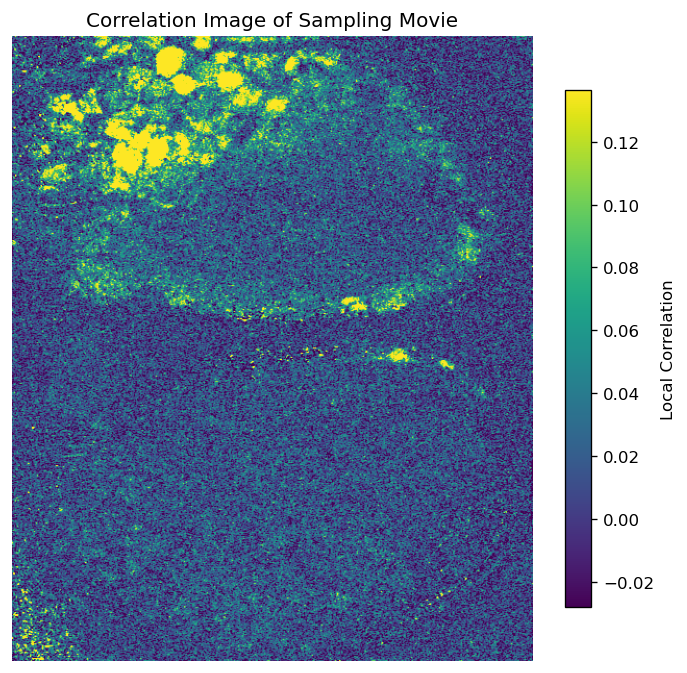

In [7]:
print("\nDisplaying correlation image from the newly created sampling movie:")

# Compute the correlation image using our existing helper function.
# The first returned value (max projection) is ignored using '_'
_, corr_img_tuple = compute_qc_images(sampling_movie)
corr_img_data, (vmin, vmax) = corr_img_tuple

# Create and display the plot.
plt.figure(figsize=(7, 7))
plt.imshow(corr_img_data, vmin=vmin, vmax=vmax, cmap='viridis')
plt.title("Correlation Image of Sampling Movie")
plt.colorbar(label="Local Correlation", shrink=0.8)
plt.axis('off')
plt.show()

### 4) CNMF Segmentation on Sampling Movie

Here, we run the core CNMF algorithm on the sampling movie. **Motion correction is NOT performed.** The goal is to identify a stable set of spatial footprints (ROIs) that are representative of the entire session.

In [8]:
# Build CNMF params for the sampling movie
# Don't worry about nperseg warning - it's annoying but not a problem. It appears once per patch.

# Build CNMF params for the sampling movie
dims = sampling_movie.shape[1:]
# Note: the movie path is still needed for some metadata in the params object
params = build_cnmf_params(str(sampling_movie_path), fr, dxy)

# Start cluster
dview = None
try:
    c, dview, n_processes = setup_cluster(backend='multiprocessing')
    print(f"[CNMF] Cluster ready with {n_processes} processes.")
except Exception as e:
    print(f"Could not start cluster, running on single process. Error: {e}")
    n_processes = 1

# Takes the in-memory numpy array (`sampling_movie`) as input
fit, fit_info = fit_cnmf(
    images=sampling_movie,
    params=params, 
    n_processes=n_processes, 
    dview=dview
)

# Print the detailed feedback from the fitting process
print(f"\n--- Fit Info --- \n{fit_info}")

# Stop cluster
if dview is not None:
    stop_server(dview=dview)
    print("\n[CNMF] Cluster stopped.")

In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


[CNMF] Cluster ready with 7 processes.
  - Converting sampling movie to CaImAn's native memory-mapped format...
  - Created temporary CaImAn-native file: /Users/mosse/caiman_data/temp/caiman_refit_movie_d1_600_d2_500_d3_1_order_C_frames_225.mmap


Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
Movie average is negative. Removing 1st percentile.
/Users/mosse/miniforge3/envs/caiman/lib/python3.11/site-packages/caiman/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/mosse/miniforge3/envs/caiman/lib/python3.11/site-packages/caiman/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/mosse/miniforge3/envs/caiman/lib/python3.11/site-packages/caiman/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. S

[CNMF] Components after initial fit: 874
  - Refitting components using the CaImAn-native movie...


/Users/mosse/miniforge3/envs/caiman/lib/python3.11/site-packages/caiman/source_extraction/cnmf/deconvolution.py:1004: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[lags + np.arange(lags)],


  - Refit complete. Delta C RMS: 3258.6
[CNMF] Components after refit: 874

--- Fit Info --- 
{'used_fit_file': True, 'did_refit': True, 'delta_C_rms': 3258.602736529513}

[CNMF] Cluster stopped.


### 5) Clean Components & Generate QC Figures

We apply morphological and shape-based filters to the ROIs found in the previous step. The output is a final, high-quality set of ROIs that will be used for trace extraction across all trials. QC figures are generated to visualize which components were kept versus discarded.

Cleaned components: kept=295, small=428, large=0, convoluted=151
--- Kept ROI Pixel Information (First 5 Rows) ---


ROI  pixel_idx   y   x  weight_raw  weight_norm
0    3      32409   9  54    0.024045     0.001749
1    3      32410  10  54    0.025674     0.001867
2    3      33009   9  55    0.024045     0.001749
3    3      33010  10  55    0.025674     0.001867
4    3      33011  11  55    0.028124     0.002045


--- Generating Summary Figure A ---


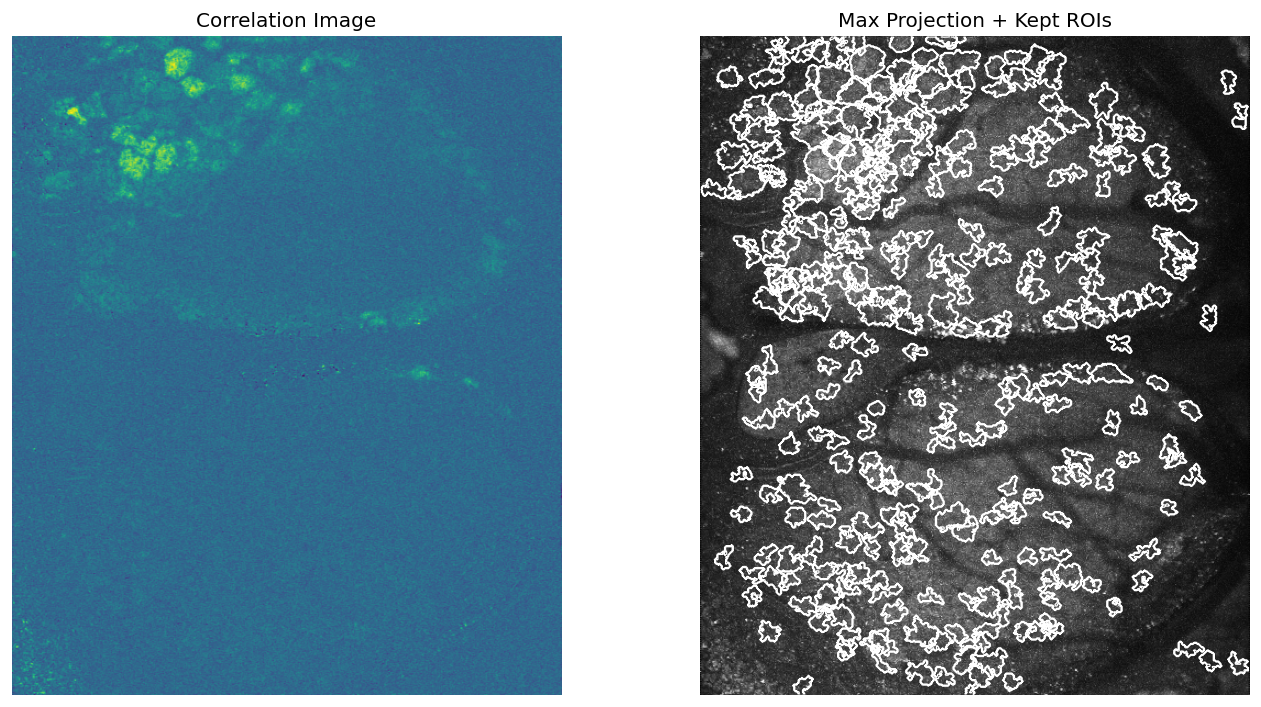

Saved summary figure to /Volumes/MossLab/ImagingData/20250829/e1/processed/outputs/summary_corr_max_overlays.png

--- Generating Detailed Diagnostic Figure ---


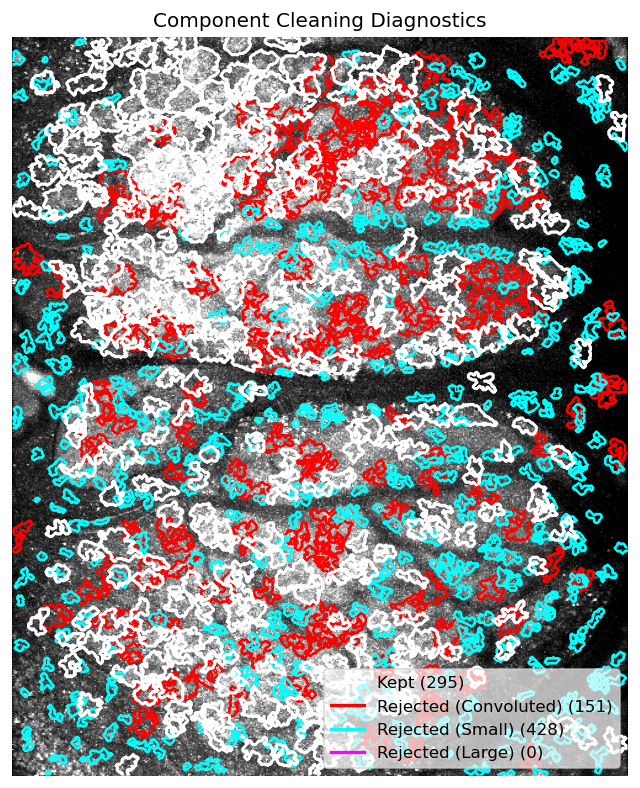

Saved diagnostic figure to /Volumes/MossLab/ImagingData/20250829/e1/processed/outputs/summary_overlay_all_classes.png


In [9]:
cleaning_params = {
    'threshold_percentile': threshold_percentile,
    'min_pixels': min_pixels,
    'max_pixels': max_pixels,
    'convolution_threshold': convolution_threshold
}
clean_results = clean_components(fit, **cleaning_params)

kept_indices = clean_results['kept_indices']
cleaned_A_list = clean_results['cleaned_A_list']

# Build the global dataframe for ROI pixel information
df_pixels = build_pixel_dataframe(fit, kept_indices)
print("--- Kept ROI Pixel Information (First 5 Rows) ---")
display(df_pixels.head())

# --- Generate QC Figure 1: Clean Summary (Correlation + Final ROIs) ---
print("\n--- Generating Summary Figure A ---")
max_proj, corr_img = compute_qc_images(sampling_movie)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(corr_img[0], cmap='viridis'); ax1.set_title('Correlation Image'); ax1.axis('off')
ax2.imshow(max_proj[0], cmap='gray'); ax2.set_title('Max Projection + Kept ROIs'); ax2.axis('off')
for contour in clean_results['contours']['valid']:
    ax2.contour(contour, colors='white', linewidths=0.75)
fig.tight_layout()
fig.savefig(summary_fig_A); plt.show()
print(f"Saved summary figure to {summary_fig_A}")


# --- Generate QC Figure 2: Detailed Diagnostic Overlay (All Components) ---
print("\n--- Generating Detailed Diagnostic Figure ---")
from matplotlib.lines import Line2D # Needed for the custom legend

fig_detail, ax_detail = plt.subplots(figsize=(8, 8))

# Use the max projection as the background
bg_img, (vmin, vmax) = max_proj
ax_detail.imshow(bg_img, cmap="gray", vmin=vmin, vmax=vmax)

# Helper function to draw contours for a specific class
def _draw_edges(ax, edge_list, color, lw):
    for edge in edge_list:
        ax.contour(edge.astype(float), levels=[0.5], colors=color, linewidths=lw)

# Plot rejected first (underlay), then kept (overlay) so white is on top
_draw_edges(ax_detail, clean_results['contours']['convoluted'], "red", 0.9)
_draw_edges(ax_detail, clean_results['contours']['small'], "cyan", 0.9)
_draw_edges(ax_detail, clean_results['contours']['large'], "magenta", 0.9)
_draw_edges(ax_detail, clean_results['contours']['valid'], "white", 1.2)

# Create proxy artists for a descriptive legend
legend_elements = [
    Line2D([0], [0], color='white', lw=2, label=f"Kept ({len(clean_results['contours']['valid'])})"),
    Line2D([0], [0], color='red', lw=2, label=f"Rejected (Convoluted) ({len(clean_results['contours']['convoluted'])})"),
    Line2D([0], [0], color='cyan', lw=2, label=f"Rejected (Small) ({len(clean_results['contours']['small'])})"),
    Line2D([0], [0], color='magenta', lw=2, label=f"Rejected (Large) ({len(clean_results['contours']['large'])})")
]
ax_detail.legend(handles=legend_elements, loc='lower right', frameon=True, framealpha=0.7)
ax_detail.set_title("Component Cleaning Diagnostics")
ax_detail.axis('off')

# Save the new, detailed figure
out_overlay_path = out_dir / "summary_overlay_all_classes.png"
fig_detail.savefig(out_overlay_path, dpi=250, bbox_inches="tight")
plt.show()
print(f"Saved diagnostic figure to {out_overlay_path}")

### 6) Process Individual Trials

Now we loop through each of the original trial videos in the `raw` directory. For each video, we:
1.  Directly load the already motion corrected trial file (motion corrected across files.
2.  Extract F, dF/F, and Z-scored traces using the globally defined set of ROIs.

In [10]:
all_trial_data = {}
trial_files = get_valid_tiff_files(mcor_dir) # Use our new robust function

# --- Check if any trial files were found ---
if not trial_files:
    # If the list is empty, print an error and raise an exception to stop execution.
    error_message = f"ERROR: No TIFF files (.tif or .tiff) were found in the specified raw directory or directory does not exist: {raw_dir.resolve()}"
    print(error_message)
    # Raising a FileNotFoundError is good practice here.
    raise FileNotFoundError(error_message)
else:
    # --- If files are found, proceed with the loop as before ---
    print(f"Found {len(trial_files)} trial videos to process...")
    
    # Wrap the loop with a tqdm progress bar.
    for trial_path in tqdm(trial_files, desc="Processing Trials"):
        trial_name = trial_path.stem # Use filename without extension as identifier
        
        # Load the raw trial movie directly (skipping motion correction).
        trial_movie_raw = cm.load(str(trial_path))
        dims = trial_movie_raw.shape[1:]
        
        # Extract Traces using the common ROIs.
        if cleaned_A_list:
            F, dFF, Z = extract_traces_for_trial(
                trial_movie=trial_movie_raw, 
                cleaned_A_list=cleaned_A_list, 
                dims=dims, 
                fr=fr
            )
            all_trial_data[trial_name] = {'F': F, 'dFF': dFF, 'Z': Z}
        else:
            # This case would only be hit if segmentation found zero valid ROIs.
            print(f"  - No kept ROIs, skipping trace extraction for {trial_name}.")
        
        # Clean up the large movie array to free up RAM before the next loop iteration.
        del trial_movie_raw

    print("\n--- All trials processed successfully! ---")

Found 45 trial videos to process...


Processing Trials:   0%|          | 0/45 [00:00<?, ?it/s]


--- All trials processed successfully! ---


### 7) Save Consolidated HDF5 Output

All data is now saved to a single HDF5 file. The file is structured with top-level groups for `roi_info` (global) and `trials`. The `trials` group contains a subgroup for each trial video, which in turn holds the `raw_F`, `dFF`, and `z_score` datasets for that trial.

In [20]:
# --- Prepare Metadata ---
meta = dict(
    source_directory=str(mcor_dir.resolve()),
    created_utc=datetime.utcnow().isoformat() + "Z",
    fr=fr, dxy=dxy, decay_time=decay_time, K_init=int(K),
    num_rois_kept=len(kept_indices),
    thresholds=cleaning_params,
    output_files=dict(
        summary_figure_A=str(summary_fig_A.resolve()),
        sampling_movie=str(sampling_movie_path.resolve())
    )
)

# --- Save to HDF5 ---
save_batch_hdf5_output(
    output_path=export_hdf5,
    df_pixels=df_pixels,
    all_trial_data=all_trial_data,
    metadata_dict=meta
)

Successfully saved all batch data to: /Volumes/MossLab/ImagingData/20250829/e1/processed/outputs/batch_analysis_results.hdf5


## Optional interactive ROI explorer
#### Requires having run Step 5 and Step 6 to have necessary variables in memory

In [17]:
import ipywidgets as widgets
from ipywidgets import interactive


# --- Check if we have the necessary data to plot ---
if 'df_pixels' not in locals() or df_pixels.empty:
    print("ERROR: Could not find 'df_pixels' DataFrame. Please run the component cleaning step (Step 5) first.")
elif 'all_trial_data' not in locals() or not all_trial_data:
    print("ERROR: Could not find 'all_trial_data'. Please run the trial processing step (Step 6) first.")
else:
    # --- Gather all the data needed for plotting ---
    kept_roi_ids = sorted(df_pixels['ROI'].unique())
    max_proj_img, (vmin, vmax) = max_proj
    dims = max_proj_img.shape
    kept_indices_list = clean_results['kept_indices']

    # --- Define the master plotting function that the widget will call ---
    def plot_roi_explorer(roi_id):
        fig, (ax_footprint, ax_traces) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [2, 3]})
        
        # --- LEFT PANEL: ROI Footprint ---
        ax_footprint.set_title(f"ROI {roi_id} Footprint")
        ax_footprint.imshow(max_proj_img, cmap='gray', vmin=vmin, vmax=vmax)
        roi_footprint_img = np.zeros(dims)
        sub_df = df_pixels[df_pixels['ROI'] == roi_id]
        if not sub_df.empty:
            roi_footprint_img[sub_df['y'].astype(int), sub_df['x'].astype(int)] = sub_df['weight_norm']
            ax_footprint.contour(roi_footprint_img, levels=[0.2 * roi_footprint_img.max()], colors='cyan', linewidths=2)
        ax_footprint.axis('off')

        # --- RIGHT PANEL: Overlaid dF/F Traces ---
        ax_traces.set_title(f"All Trial dF/F Traces for ROI {roi_id}")
        
        try:
            roi_index = kept_indices_list.index(roi_id)
            
            # --- Traces are one color, fine, and semi-transparent ---
            trace_color = 'royalblue'
            for trial_name, trial_data in all_trial_data.items():
                dff_trace = trial_data['dFF'][roi_index, :]
                time_s = np.arange(len(dff_trace)) / fr
                ax_traces.plot(time_s, dff_trace, color=trace_color, lw=0.8, alpha=0.4)
            
            # --- Add a transparent box over the 5-6 second odor period ---
            ax_traces.axvspan(5, 6, color='limegreen', alpha=0.2, label='Odor Window')
            
            # Add a legend for just the odor box
            ax_traces.legend(loc='upper right')
            
            ax_traces.set_xlabel("Time (s)")
            ax_traces.set_ylabel("dF/F")
            ax_traces.spines[['top', 'right']].set_visible(False)
            ax_traces.axhline(0, color='black', linestyle='--', linewidth=0.5, alpha=0.5) # Add a zero line
            
        except (ValueError, IndexError):
            ax_traces.text(0.5, 0.5, f"Could not find index for ROI {roi_id}", ha='center', va='center')
        except Exception as e:
            ax_traces.text(0.5, 0.5, f"An error occurred: {e}", ha='center', va='center')

        plt.tight_layout()
        plt.show()

    # --- Use an IntSlider for the ROI selector ---
    # The slider will show the actual ROI ID, not just its position in the list.
    interactive_plot = interactive(
        plot_roi_explorer,
        roi_id=widgets.SelectionSlider(
            options=kept_roi_ids,
            value=kept_roi_ids[0], # Start with the first ROI
            description='Select ROI ID:',
            continuous_update=False, # Only update plot when slider is released
            orientation='horizontal',
            readout=True,
            style={'description_width': 'initial'}
        )
    )
    
    # Display the final widget
    display(interactive_plot)

interactive(children=(SelectionSlider(continuous_update=False, description='Select ROI ID:', options=(3, 4, 6,…

### 8) Final Cleanup (Optional)

This final step cleans up all the temporary memory-mapped (`.mmap`) files created by CaImAn during the motion correction of each individual trial.

In [18]:
caiman_temp_dir = Path.home() / 'caiman_data' / 'temp'
print(f"--- Starting Cleanup of CaImAn Temporary Files ---")
print(f"Target directory: {caiman_temp_dir}")

if caiman_temp_dir.is_dir():
    try:
        temp_files = [f for f in caiman_temp_dir.iterdir() if f.is_file()]
        if not temp_files:
            print("Status: Temporary directory is empty. No files to delete.")
        else:
            num_deleted = 0
            for f_path in temp_files:
                try:
                    f_path.unlink()
                    num_deleted += 1
                except OSError as e:
                    print(f"  - ERROR: Could not delete {f_path.name}. Reason: {e}")
            print(f"\nCleanup complete. Successfully deleted {num_deleted} file(s).")
    except Exception as e:
        print(f"An unexpected error occurred during cleanup: {e}")
else:
    print("Status: Temporary directory not found. No cleanup was necessary.")

--- Starting Cleanup of CaImAn Temporary Files ---
Target directory: /Users/mosse/caiman_data/temp

Cleanup complete. Successfully deleted 3 file(s).
